# Defining and Training Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from numpy import log, sqrt, log2, ceil, exp
import matplotlib.pyplot as plt

## Load Data

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.customer = sequences[:, :-1]
        self.vendor = sequences[:, -1:].view(-1)

    def __len__(self):
        return len(self.vendor)

    def __getitem__(self, idx):
        return self.customer[idx,:], self.vendor[idx]

In [3]:
with open("ProcessedData/train_sequences_padded_dataset.pkl", "rb") as file:
    train_sequences_padded_dataset = pickle.load(file)

with open("ProcessedData/vendors_tensor.pkl", "rb") as file:
    vendors_tensor = pickle.load(file)

## Define Model

### Model 1
<p align="center">
  <img src="Imgs/Recommender1.png" width="1000"/>
</p>

In [4]:
# Define column indices to split columns into chunks (hard-coded)

cont_idx_lo = 0
cont_idx_hi = 8     # Up to avg_sale_log
misc_idx_hi = 12    # Up to rank
ptag_idx_hi = 55    # Up to primary_tags_is_42
vtag_idx_hi = 123   # Up to vendor_tag_is_67

In [5]:
print(ceil(log2(67)))   # vtag embed size

7.0


In [6]:
print(ceil(log2(42)))   # ptag embed size

6.0


In [7]:
print(2 * ceil(log2(12+6+7)))   # final embed size

10.0


In [8]:
from Models.Models import Model1

model1 = Model1(vendors=vendors_tensor, cont_idx_hi=cont_idx_hi, misc_idx_hi=misc_idx_hi, ptag_idx_hi=ptag_idx_hi, vtag_idx_hi=vtag_idx_hi, d_fc=64)

### Loss Function

To train our model, we will use a type of ranking loss function. A ranking loss takes as input the scores of a positive sample and a negative sample. The output is
$$\textrm{loss}(x_+, x_-) = \textrm{max}(0, x_- - x_+)$$
The loss is $0$ when the positive sample is ranked higher than or equal to the negative sample, and is greater than $0$ otherwise. 

In [9]:
mr_loss = nn.MarginRankingLoss()

### Optimizer

In [10]:
adam = torch.optim.Adam(model1.parameters())

## Training

In [11]:
# Define DataLoaders

batch_size = 512
num_workers = 0
train_loader = torch.utils.data.DataLoader(dataset=train_sequences_padded_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [12]:
# Define the training process for Model 1

epochs = 100
print_every = 10
save_every = 10

train_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = torch.randint(low=1, high=100, size=v_id.size())

        # Get scores
        pos_pred = model1.forward(c_seq, v_id)
        neg_pred = model1.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()
        train_losses.append(batch_loss.item())

        # Update parameters
        batch_loss.backward()
        adam.step()

        # Reset gradients
        adam.zero_grad()
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')
    if epoch % save_every == 0:
        PATH = f"Models/model1_epoch{epoch}.pkl"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model1.state_dict(),
            'optimizer_state_dict': adam.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:\tsum(batch_losses) = {running_loss}')
PATH = f"Models/model1_epoch{epochs}.pkl"
torch.save({
    'epoch': epochs,
    'model_state_dict': model1.state_dict(),
    'optimizer_state_dict': adam.state_dict(),
    'loss': mr_loss,
    }, PATH)
print('Done!')

Epoch [0/100]:	sum(batch_losses) = 0.13528824835157138
Epoch [10/100]:	sum(batch_losses) = 0.0009799046192711103
Epoch [20/100]:	sum(batch_losses) = 0.0001918016000388434
Epoch [30/100]:	sum(batch_losses) = 0.00011358720138332501
Epoch [40/100]:	sum(batch_losses) = 4.221813595961521e-05
Epoch [50/100]:	sum(batch_losses) = 1.344618256382546e-05
Epoch [60/100]:	sum(batch_losses) = 8.290946862388182e-06
Epoch [70/100]:	sum(batch_losses) = 2.1479427552151265e-06
Epoch [80/100]:	sum(batch_losses) = 1.2740819443912699e-06
Epoch [90/100]:	sum(batch_losses) = 1.1285788215076309e-06
Epoch [100/100]:	sum(batch_losses) = 9.971895233995554e-07
Done!


In [13]:
print(f'num batches: {len(train_losses)}')
print(f'batches per epoch: {len(train_losses) // epochs}')

num batches: 20400
batches per epoch: 204


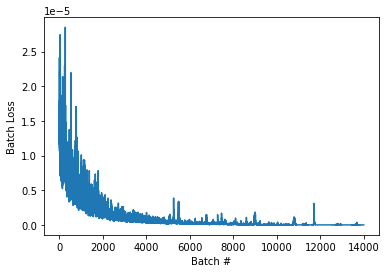

In [14]:
plt.plot(range(len(train_losses[1000:15000])), train_losses[1000:15000])
plt.xlabel('Batch #')
plt.ylabel('Batch Loss')
plt.show()